In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB

# Pima India Diabetes Dataset

## Download and initial analysis

In [19]:
df1 = pd.read_csv('Pima_India_Diabetes.csv')

In [20]:
df1.duplicated().sum()

np.int64(0)

In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [22]:
df1.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [23]:
df1.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


features like glucose, blood pressure, skin thickness, insulin and bmi cannot be 0. Thus, they must have been NaN values

## erroneous data correction and imputation

In [24]:
invalid_features = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]
for col in invalid_features:
    print(f"{col} zeros: {(df1[col]==0).sum()}")

print()
df1[invalid_features] = df1[invalid_features].replace(0, np.nan)
print("new null values")
print(df1.isnull().sum())

Glucose zeros: 5
BloodPressure zeros: 35
SkinThickness zeros: 227
Insulin zeros: 374
BMI zeros: 11

new null values
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


In [25]:
imputer = KNNImputer(n_neighbors=5)

features = ['Glucose', 'BMI', 'BloodPressure']

df1[features] = imputer.fit_transform(df1[features])

print("Missing values after KNN imputation:")
print(df1[features].isnull().sum())

Missing values after KNN imputation:
Glucose          0
BMI              0
BloodPressure    0
dtype: int64


In [26]:
nan_insulin = df1['Insulin'].isnull()

df1.loc[nan_insulin, 'Insulin'] = (
    (df1.loc[nan_insulin, 'Glucose'] *df1.loc[nan_insulin, 'BMI']) /
    df1.loc[nan_insulin, 'Age']
)

print("Missing values after imputing Insulin with formula:")
print(df1['Insulin'].isnull().sum())

Missing values after imputing Insulin with formula:
0


In [27]:
skin_train = df1.dropna(subset=['SkinThickness'])
skin_test = df1[df1['SkinThickness'].isnull()]

features = ['BMI', 'Glucose', 'BloodPressure']
target = 'SkinThickness'

X_train = skin_train[features]
y_train = skin_train[target]
X_test = skin_test[features]

model = KNeighborsRegressor(n_neighbors=5)
model.fit(X_train, y_train)

y_test = model.predict(X_test)

df1.loc[skin_test.index, 'SkinThickness'] = y_test

print("Missing values after regression imputation for SkinThickness:")
print(df1['SkinThickness'].isnull().sum())

Missing values after regression imputation for SkinThickness:
0


## Outcome related analysis

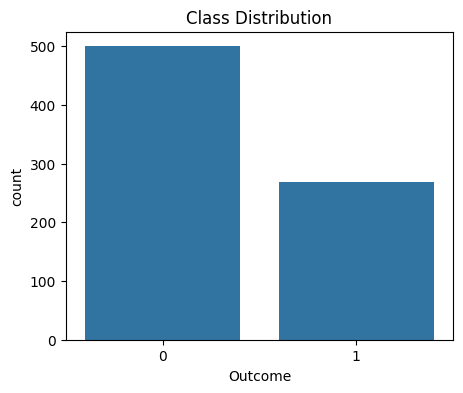

In [28]:
plt.figure(figsize=(5, 4))
sns.countplot(x="Outcome", data=df1)
plt.title("Class Distribution")
plt.show()

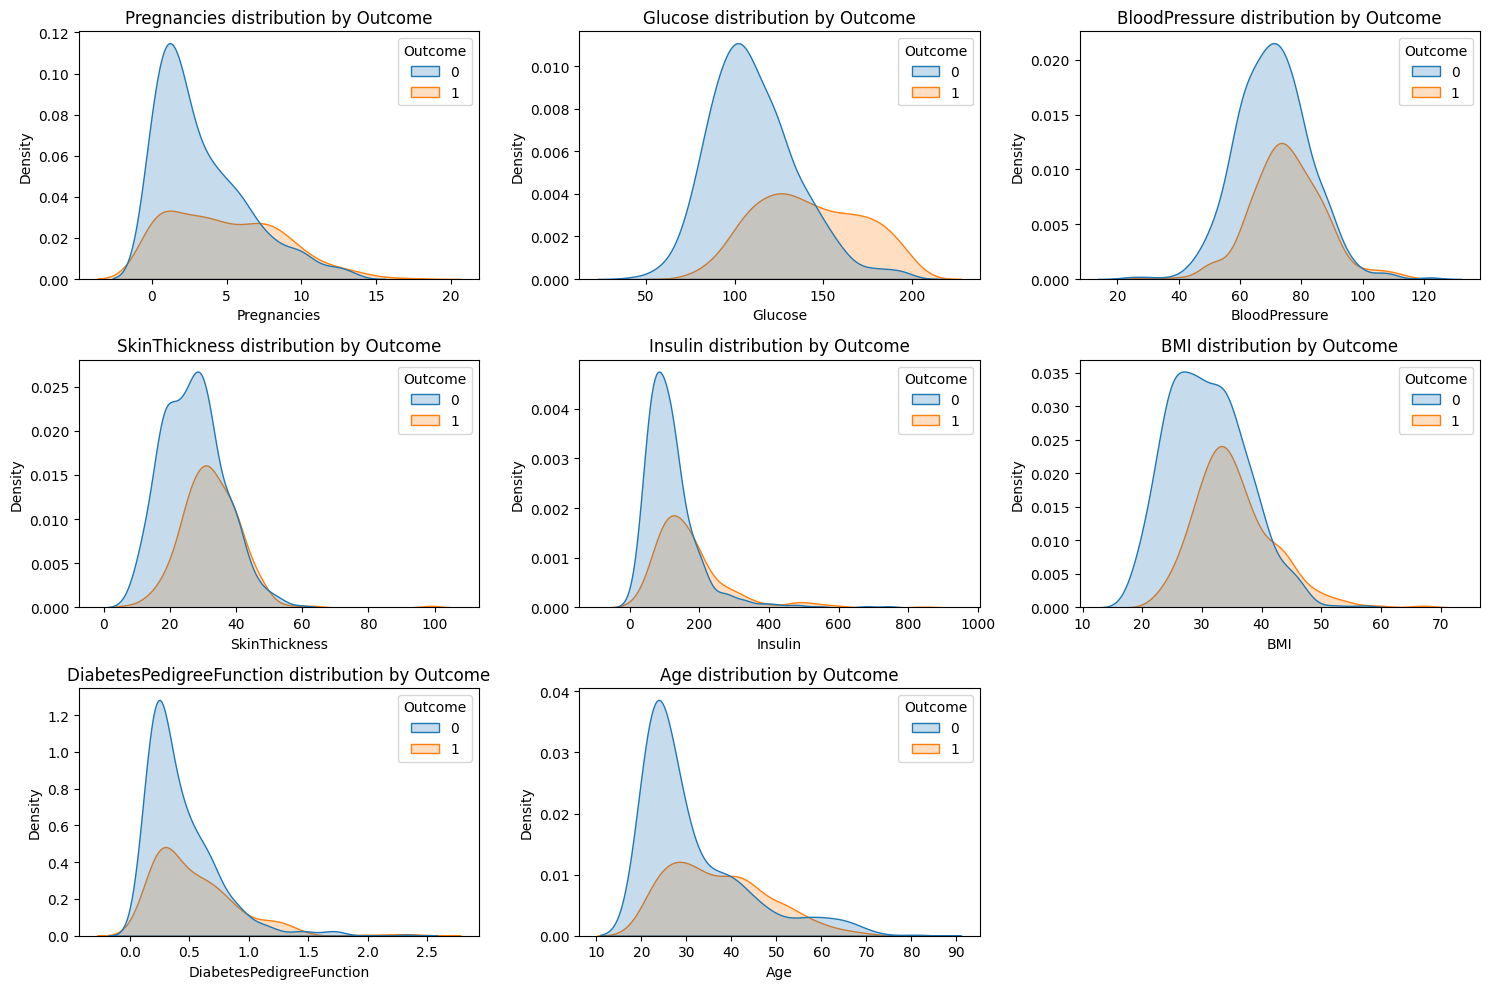

In [29]:
plt.figure(figsize=(15,10))
for i, col in enumerate(df1.columns[:-1], 1):
    plt.subplot(3,3,i)
    sns.kdeplot(data=df1, x=col, hue="Outcome", fill=True)
    plt.title(f"{col} distribution by Outcome")
plt.tight_layout()
plt.show()


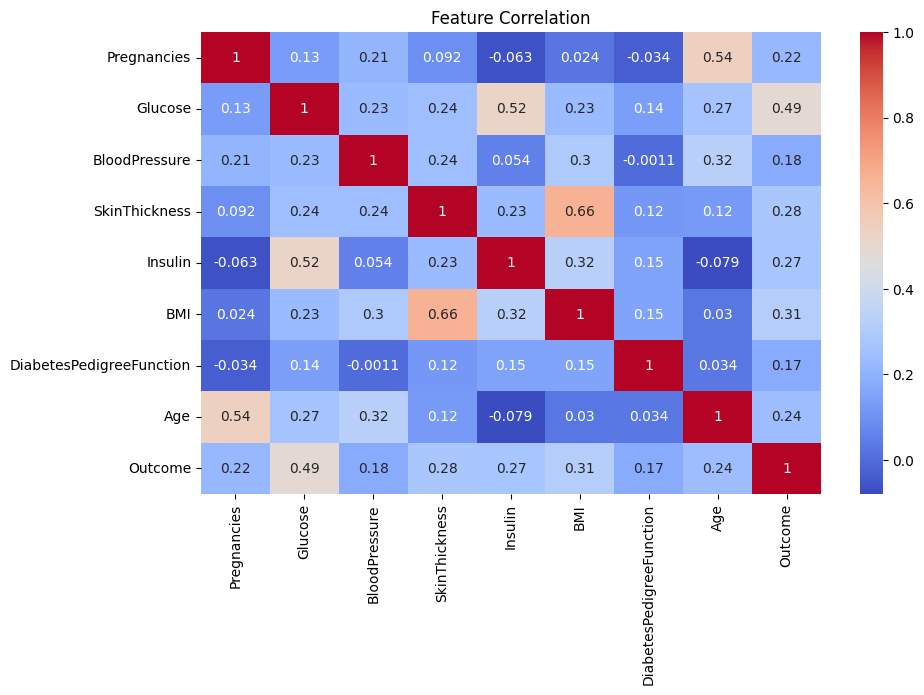

In [30]:
plt.figure(figsize=(10, 6))
sns.heatmap(df1.corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation")
plt.show()

## Outliers

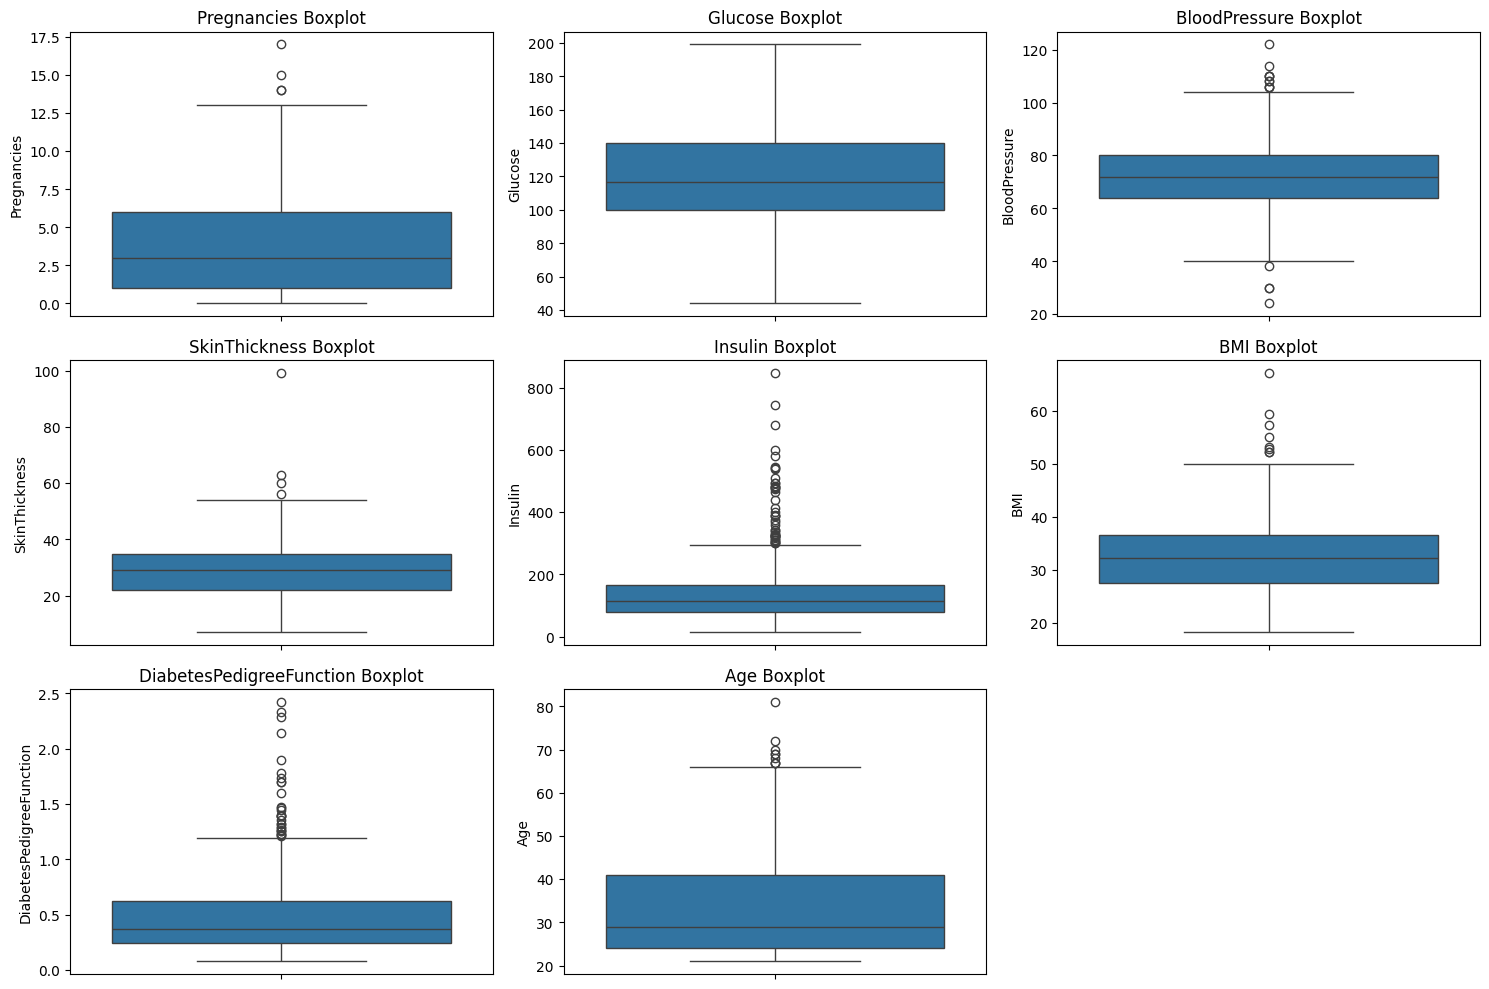

In [31]:
plt.figure(figsize=(15,10))
for i, col in enumerate(df1.columns[:-1], 1):
    plt.subplot(3,3,i)
    sns.boxplot(y=df1[col])
    plt.title(f"{col} Boxplot")
plt.tight_layout()
plt.show()


In [32]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1
outliers = ((df1 < (Q1 - 1.5*IQR)) | (df1 > (Q3 + 1.5*IQR))).sum()
print("Outliers count per column:\n", outliers)

Outliers count per column:
 Pregnancies                  4
Glucose                      0
BloodPressure               14
SkinThickness                4
Insulin                     43
BMI                          8
DiabetesPedigreeFunction    29
Age                          9
Outcome                      0
dtype: int64


In [33]:
Q1 = df1.quantile(0.25)
Q3 = df1.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ((df1 < (Q1 - 1.5 * IQR)) | (df1 > (Q3 + 1.5 * IQR)))
outlier_rows = df1[outlier_mask.any(axis=1)]

print("Rows identified as outliers based on IQR:")
display(outlier_rows)

Rows identified as outliers based on IQR:


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137.0,40.0,35.0,168.000000,43.1,2.288,33,1
8,2,197.0,70.0,45.0,543.000000,30.5,0.158,53,1
12,10,139.0,80.0,26.0,66.085965,27.1,1.441,57,0
13,1,189.0,60.0,23.0,846.000000,30.1,0.398,59,1
18,1,103.0,30.0,38.0,83.000000,43.3,0.183,33,0
...,...,...,...,...,...,...,...,...,...
695,7,142.0,90.0,24.0,480.000000,30.4,0.128,43,1
707,2,127.0,46.0,21.0,335.000000,34.4,0.176,22,0
710,3,158.0,64.0,13.0,387.000000,31.2,0.295,24,0
715,7,187.0,50.0,33.0,392.000000,33.9,0.826,34,1


### In medical datasets, all outliers are important data

## Skewness identification

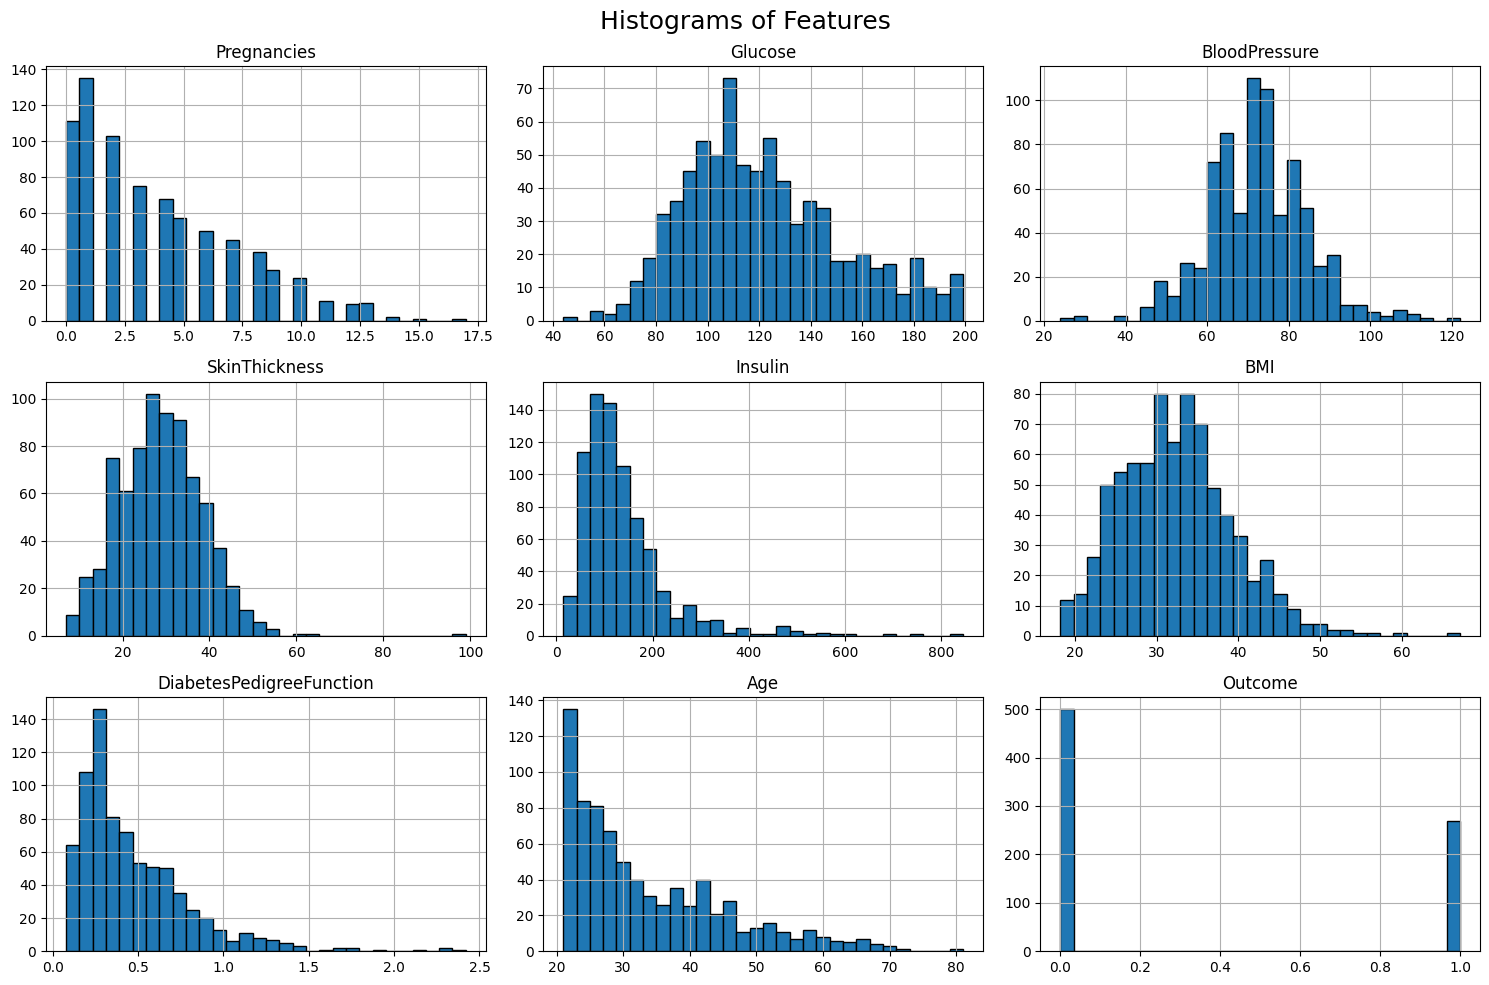

In [34]:
df1.hist(bins=30, figsize=(15,10), edgecolor="black")
plt.suptitle("Histograms of Features", size=18)
plt.tight_layout()
plt.show()

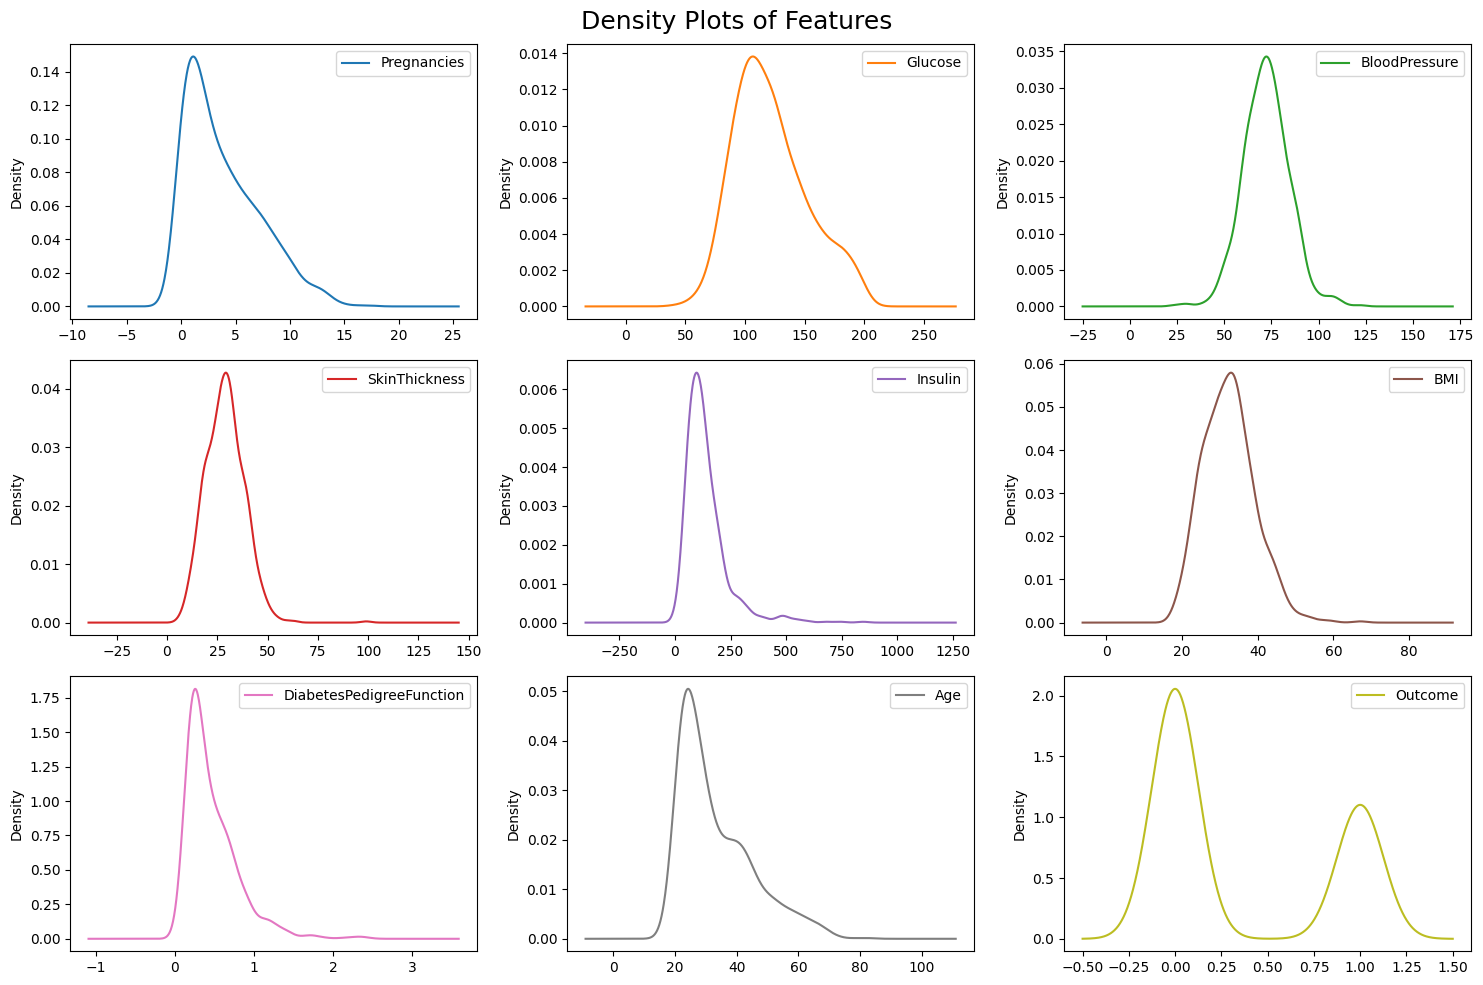

In [35]:
df1.plot(kind="density", subplots=True, layout=(3,3), figsize=(15,10), sharex=False, sharey=False)
plt.suptitle("Density Plots of Features", size=18)
plt.tight_layout()
plt.show()

In [36]:
df1.skew()

,0
Pregnancies,0.901674
Glucose,0.536043
BloodPressure,0.142964
SkinThickness,0.695573
Insulin,2.648926
BMI,0.592324
DiabetesPedigreeFunction,1.919911
Age,1.129597
Outcome,0.635017


In [37]:
skewed_features = ['Pregnancies', 'DiabetesPedigreeFunction']

X = df1.drop('Outcome', axis=1)
y = df1['Outcome']
X_skew = X.drop(skewed_features, axis=1)

## KNN Classification

### Model 1 : KNN on whole dataset without decreasing skew



In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 26, 'weights': 'uniform'}
Best cross-validation accuracy: 0.7541250166600026
Test set accuracy: 0.7662337662337663


In [39]:
print(classification_report(best_knn.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.88      0.78      0.83       111
           1       0.56      0.72      0.63        43

    accuracy                           0.77       154
   macro avg       0.72      0.75      0.73       154
weighted avg       0.79      0.77      0.77       154



### Model 2 : KNN on dataset without decreasing skew and not including features -  Pregnancies, DiabetesPedigreeFunction

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X_skew, y, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 46, 'weights': 'uniform'}
Best cross-validation accuracy: 0.7590430494468879
Test set accuracy: 0.7792207792207793


In [41]:
print(classification_report(best_knn.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       109
           1       0.60      0.73      0.66        45

    accuracy                           0.78       154
   macro avg       0.74      0.77      0.75       154
weighted avg       0.80      0.78      0.78       154



### Feature Scaling data

In [42]:
df2 = df1.copy()
for col in ['Insulin', 'DiabetesPedigreeFunction', 'Age']:
    df2[col] = np.log1p(df2[col])
scaler = StandardScaler()
df2[['Glucose','BMI','Age','Insulin','DiabetesPedigreeFunction']] = scaler.fit_transform(
    df2[['Glucose','BMI','Age','Insulin','DiabetesPedigreeFunction']]
)
df2.skew()

,0
Pregnancies,0.901674
Glucose,0.536043
BloodPressure,0.142964
SkinThickness,0.695573
Insulin,0.035154
BMI,0.592324
DiabetesPedigreeFunction,1.117942
Age,0.614664
Outcome,0.635017


In [43]:
X1 = df2.drop('Outcome', axis=1)
y1 = df2['Outcome']
X1_skew = X1.drop(skewed_features, axis=1)

### Model 3 : KNN on scaled complete dataset

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 6, 'weights': 'distance'}
Best cross-validation accuracy: 0.7183126749300279
Test set accuracy: 0.6883116883116883


In [45]:
print(classification_report(best_knn.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.78      0.75      0.76       103
           1       0.53      0.57      0.55        51

    accuracy                           0.69       154
   macro avg       0.65      0.66      0.65       154
weighted avg       0.69      0.69      0.69       154



### Model 4 : KNN on scaled dataset without columns having skew > 0.70

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X1_skew, y1, test_size=0.2, random_state=42)

knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': list(range(1, 50)),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}


grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')
grid.fit(X_train, y_train)


print("Best parameters:", grid.best_params_)
print("Best cross-validation accuracy:", grid.best_score_)

best_knn = grid.best_estimator_
y_pred = best_knn.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Best parameters: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}
Best cross-validation accuracy: 0.7215380514460883
Test set accuracy: 0.6428571428571429


In [47]:
print(classification_report(best_knn.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.74      0.72      0.73       102
           1       0.47      0.50      0.49        52

    accuracy                           0.64       154
   macro avg       0.61      0.61      0.61       154
weighted avg       0.65      0.64      0.65       154



### Thus we conclude that the near-optimal KNN model for the Pima India Diabetes dataset is Model 2 with an accuracy of 0.7792 for its test set

## Decision Tree Classifier

### Model 1 : Basic model

In [48]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Test set accuracy: 0.6948051948051948


In [49]:
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.73      0.78      0.75        92
           1       0.64      0.56      0.60        62

    accuracy                           0.69       154
   macro avg       0.68      0.67      0.68       154
weighted avg       0.69      0.69      0.69       154



### Applying Hyper Parameter Tuning

In [50]:
param = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

model = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator=model, param_grid=param, cv=3)
grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

Best parameters: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5}
Best cross-validation accuracy: 0.7638689622190339


In [51]:
# finer hyperparameter tuning

param = {
    'criterion': ['gini'],
    'max_depth' : [i for i in range(3,10,1)],
    'min_samples_split': [i for i in range(3,10,1)],
    'min_samples_leaf': [2, 3],
    'max_features': ['log2']
}

grid_search1 = GridSearchCV(estimator=model, param_grid=param, cv=3)
grid_search1.fit(X_train, y_train)

print("Best parameters:", grid_search1.best_params_)
print("Best cross-validation accuracy:", grid_search1.best_score_)

Best parameters: {'criterion': 'gini', 'max_depth': 4, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 8}
Best cross-validation accuracy: 0.7573409851745576


In [52]:
param = grid_search1.best_params_
model = DecisionTreeClassifier(**param)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Test set accuracy: 0.6623376623376623


In [53]:
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.61      0.82      0.70        73
           1       0.76      0.52      0.62        81

    accuracy                           0.66       154
   macro avg       0.68      0.67      0.66       154
weighted avg       0.69      0.66      0.66       154



## Naive Bayes

In [54]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test set accuracy:", accuracy_score(y_test, y_pred))

Test set accuracy: 0.7272727272727273


In [55]:
print(classification_report(model.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.76      0.81      0.78        93
           1       0.67      0.61      0.64        61

    accuracy                           0.73       154
   macro avg       0.72      0.71      0.71       154
weighted avg       0.72      0.73      0.72       154



## Result : Based on the test set accuracies calculated in the notebook, the best performing model is KNN Model 2, which achieved a test set accuracy of 0.7792.